In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
import yaml
import sys

from tqdm import tqdm
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy.stats import ks_2samp
from statsmodels.distributions.empirical_distribution import ECDF

sys.path.append("../../../../utils")
from absolute_path_builder import AbsolutePathBuilder

In [2]:
plt.rcParams['figure.figsize']  = (3.33, 5.5)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 24
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3

#### Build Buckeye's data description

In [3]:
buckeye_datapath = AbsolutePathBuilder.get_path(
    "04_buckeye_scored",
    filepaths="../../../../config/filepaths.yaml"
)

df_buckeye = pd.concat(
    [pd.read_csv(file) for file in glob.glob(os.path.join(buckeye_datapath, "*"))]
)
df_buckeye["group"] = "White"

#### Build CORAAL's data description

In [4]:
coraal_datapath = AbsolutePathBuilder.get_path(
    "04_coraal_scored",
    filepaths="../../../../config/filepaths.yaml"
)

df_coraal = pd.concat(
    [pd.read_csv(file) for file in glob.glob(os.path.join(coraal_datapath, "*"))]
)
df_coraal["group"] = "Black"

In [5]:
df_complete = pd.concat([df_coraal, df_buckeye])

df_complete = df_complete[~df_complete.has_swearing]

---

### Toxicity Score Cumulative Distribution Function (CDF)

100%|███████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 51.73it/s]


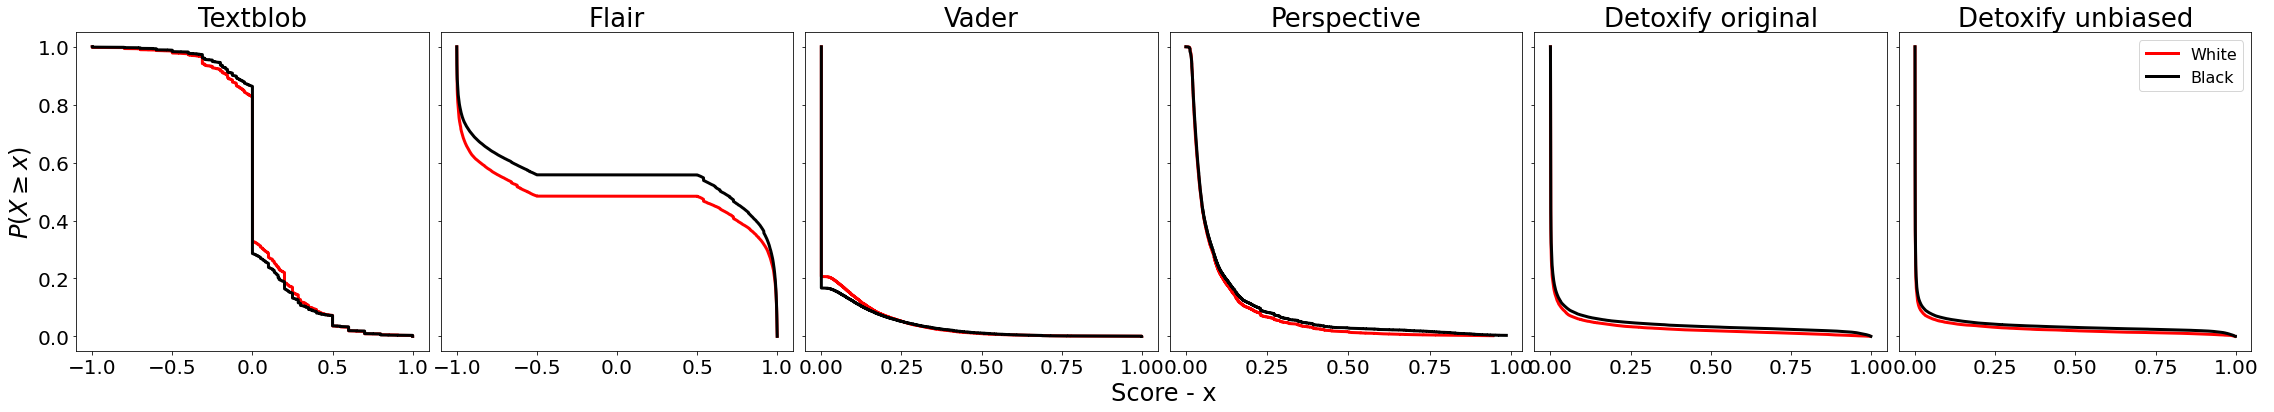

In [6]:
group_color = {
    "White": "red",
    "Black": "black",
}

fig, axs = plt.subplots(1, 6, figsize=(32, 6), sharey=True)

for i, SCORE_NAME in enumerate(
    tqdm(
        [
            "textblob",
            "flair",
            "vader",
            "perspective",
            "detoxify_original",
            "detoxify_unbiased",
        ]
    )
):
    # axins = zoomed_inset_axes(axs[i], 5, loc=1)
    for group in group_color.keys():
        df = df_complete[df_complete.group == group]

        ecdf = ECDF(df[f"{SCORE_NAME}_score"])
        axs[i].plot(ecdf.x, 1-ecdf.y, label=group, c=group_color[group])
        
        # Add a subaxis with the same traces
        # axins.plot(ecdf.x, 1-ecdf.y, label=group, c=group_color[group])
    
    axs[i].set_title(f"{SCORE_NAME.replace('_', ' ').capitalize()}", fontsize=26)
#     axs[i].set_xlim(-0.01, 1)

    # The slice of the axis that will be zoomed in
    # axins.set_xlim(0.92, 1)
    # axins.set_ylim(-0.01, 0.05)

    # Draw a bbox of the region of the inset axes in the parent axes and
    # connecting lines between the bbox and the inset axes area
    # mark_inset(axs[i], axins, loc1=3, loc2=4, fc="none", ec="0.5")
    
    # plt.xticks(visible=False)
    # plt.yticks(visible=False)

plt.legend()

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Score - x", fontsize=24)
plt.ylabel(r"$P(X \geq x)$", fontsize=24)
plt.tight_layout(pad=0)
plt.savefig(
    os.path.join(
        AbsolutePathBuilder.get_path(
            "buckeye_vs_coraal_imgs",
            filepaths="../../../../config/filepaths.yaml"
        ),
        f"buckeye_vs_coraal_icdfs_appendix_wo_swear.pdf"
    )
)
plt.show()

---

### Two-Sample Kolmogorov-Smirnov's Test

In [7]:
ks_all = []
groups = df.group.unique()
for first_group in groups:
    ks_one_vs_all = []
    for second_group in groups:
        statistic, p_value = ks_2samp(
            df[df.group == first_group][score_name],
            df[df.group == second_group][score_name]
        )
        
        ks_one_vs_all.append(
            f"{np.abs(np.round(statistic*100, 3))} ({np.round(p_value*100, 3)})"
        )
    ks_all.append(ks_one_vs_all)

NameError: name 'score_name' is not defined

In [ ]:
pd.DataFrame(ks_all, columns=groups, index=groups)